# QNN Example

## qiskit example

From here https://qiskit.org/documentation/machine-learning/tutorials/02_neural_network_classifier_and_regressor.html

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from IPython.display import clear_output

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

algorithm_globals.random_seed = 42

In [43]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [44]:
df = pd.read_csv('datasets/vlds.csv', index_col=0)
df.head()

,feature_1,feature_2,feature_3,feature_4,label
0,9.0,9.0,8.0,11.0,0.0
1,6.0,11.0,24.0,3.0,1.0
2,12.0,9.0,12.0,20.0,0.0
3,8.0,18.0,27.0,4.0,1.0
4,5.0,15.0,25.0,4.0,1.0


In [45]:
features = df.iloc[:, 0:4].values
labels = df.loc[:, ['label']].values.flatten()

In [46]:
# construct QNN
opflow_qnn = TwoLayerQNN(4, quantum_instance=quantum_instance)
# QNN maps inputs to [-1, +1]
opflow_qnn.forward(features[0, :], algorithm_globals.random.random(opflow_qnn.num_weights))

array([[-0.24023438]])

In [47]:
opflow_qnn.circuit.draw()

┌────────────────────────────────────┐»
q_0: ┤0                                   ├»
     │                                    │»
q_1: ┤1                                   ├»
     │  ZZFeatureMap(x[0],x[1],x[2],x[3]) │»
q_2: ┤2                                   ├»
     │                                    │»
q_3: ┤3                                   ├»
     └────────────────────────────────────┘»
«     ┌────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                       ├
«     │                                                                                                        │
«q_1: ┤1                                                                                                       ├
«     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11],θ[12],θ[13],θ[14],θ[15]) │
«q_2: ┤2                                                                                                       ├
«     │                                                                                                        │
«q_3: ┤3                                                                                                       ├
«     └────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [48]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [49]:
# construct neural network classifier
opflow_classifier = NeuralNetworkClassifier(opflow_qnn, optimizer=COBYLA(50), callback=callback_graph)

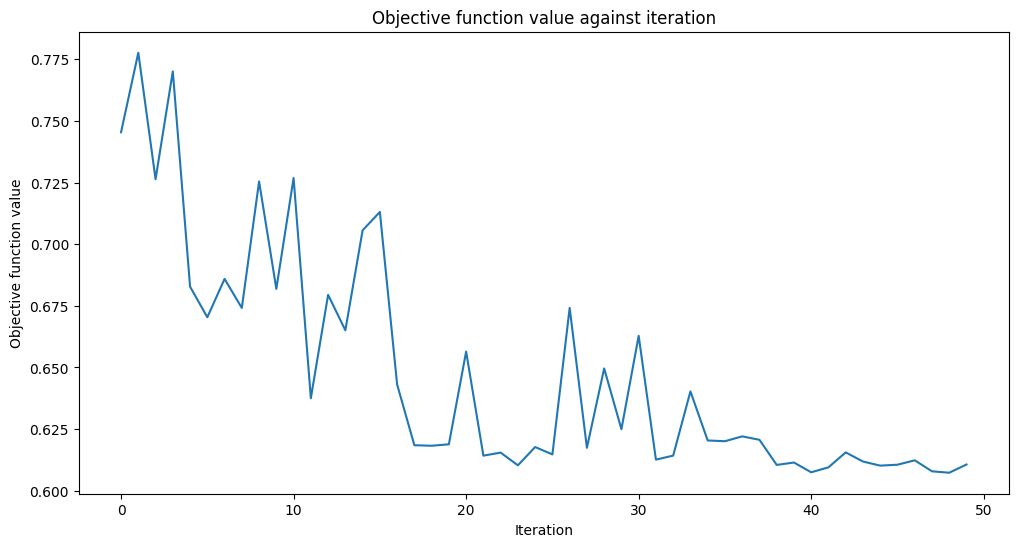

0.45

In [50]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(features, labels)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(features, labels)

## Evaluation of Quantum Machine Learning Algorithms

One possible solution

In [51]:
circuit = QuantumCircuit(4)

#Input layer
circuit.ry(Parameter('i_1'),0)
circuit.ry(Parameter('i_2'),1)
circuit.ry(Parameter('i_3'),2)
circuit.ry(Parameter('i_4'),3)

#mixing/training layer, can very different. comparable to classical setup of NN, i.e. LSTM, hidden layers, activation functions. Still unclear which is good and what works best
circuit.rx(Parameter('w_1'),0)
circuit.crz(Parameter('w_12'),0,1)
circuit.rx(Parameter('w_2'),1)
circuit.crz(Parameter('w_23'),1,2)
circuit.rx(Parameter('w_3'),2)
circuit.crz(Parameter('w_34'),2,3)
circuit.rx(Parameter('w_4'),3)
circuit.crz(Parameter('w_41'),3,0)

circuit.draw()

┌─────────┐┌─────────┐                                              »
q_0: ┤ Ry(i_1) ├┤ Rx(w_1) ├─────■────────────────────────────────────────»
     ├─────────┤└─────────┘┌────┴─────┐┌─────────┐                       »
q_1: ┤ Ry(i_2) ├───────────┤ Rz(w_12) ├┤ Rx(w_2) ├─────■─────────────────»
     ├─────────┤           └──────────┘└─────────┘┌────┴─────┐┌─────────┐»
q_2: ┤ Ry(i_3) ├──────────────────────────────────┤ Rz(w_23) ├┤ Rx(w_3) ├»
     ├─────────┤                                  └──────────┘└─────────┘»
q_3: ┤ Ry(i_4) ├─────────────────────────────────────────────────────────»
     └─────────┘                                                         »
«                            ┌──────────┐
«q_0: ───────────────────────┤ Rz(w_41) ├
«                            └────┬─────┘
«q_1: ────────────────────────────┼──────
«                                 │      
«q_2: ─────■──────────────────────┼──────
«     ┌────┴─────┐┌─────────┐     │      
«q_3: ┤ Rz(w_34) ├┤ Rx(w_4) ├─────■──────
«     └──────────┘└─────────┘

In [52]:
def parity(x):
    return x%2#how many labels?

output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [53]:
#training setup
circuit_qnn = CircuitQNN(circuit=circuit,    
                         input_params=circuit.parameters[0:4],
                         weight_params=circuit.parameters[4:],
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

    # construct classifier
circuit_classifier= NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                            optimizer=COBYLA(),
                            callback=callback_graph)

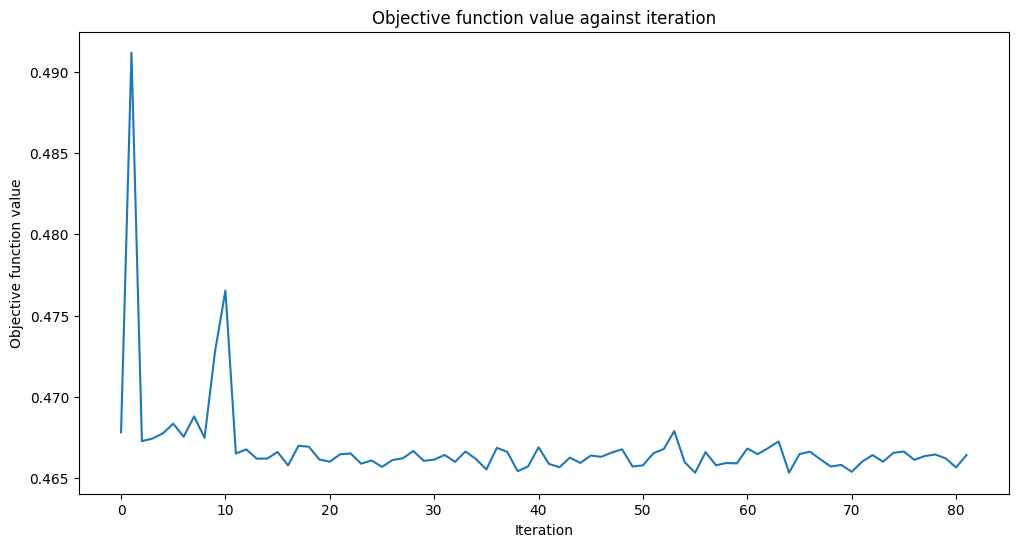

0.546

In [54]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
circuit_classifier.fit(features, labels)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
circuit_classifier.score(features, labels)